# CV Model

### Data Prep

In [1]:
# Import required libraries
import tensorflow as tf
import os
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample



pd.set_option('display.max_rows', 500)

In [2]:
# Define globals
data_directory = 'C:/Users/kflin/Downloads/song_data' #dataset path
fs = 5  # Sampling frequency for piano rolls
labeled_midi_data = {}

def load_midi_data_and_labels(directory):
    skipped_files = []    # Keep track of skipped files due to errors
    data = []
    composers = []
    num_composer_map = {}
    # Function to recursively iterate files in a directory
    def iterate_dir(dir_path, label, composer):        
        # Check direct .mid files in current directory
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) and item_path.endswith('.mid'):
                try:
                    # Load the MIDI file
                    midi_data = pretty_midi.PrettyMIDI(item_path)
                    data.append(midi_data)
                    composers.append(label)
                    if label not in labeled_midi_data:
                        labeled_midi_data[label] = []
                    labeled_midi_data[label].append(midi_data)

                except Exception as e:  # Catch any exception that might be raised
                    print(f"Skipping file {item_path} due to an error: {e}")
                    skipped_files.append(item_path)
            elif os.path.isdir(item_path):
                iterate_dir(item_path, label, composer)
        print(f"Number of files skipped due to error: {len(skipped_files)}")
        return

    # Process each composer's directory in the root directory
    for label, composer in enumerate(sorted(os.listdir(directory))):
        composer_path = os.path.join(directory, composer)
        if os.path.isdir(composer_path):
            num_composer_map[label] = composer
            iterate_dir(composer_path, label, composer)

    return np.array(data), np.array(composers), num_composer_map

_, _, num_composer_map = load_midi_data_and_labels(data_directory)

Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0


c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Skipping file C:/Users/kflin/Downloads/song_data\Beethoven\Anhang 14-3.mid due to an error: Could not decode key with 3 flats and mode 255
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Skipping file C:/Users/kflin/Downloads/song_data\Mozart\Piano

In [3]:
# print number of songs per composer
for composer, songs in labeled_midi_data.items():
    print(f"Composer {composer} has {len(songs)} songs")

Composer 0 has 925 songs
Composer 1 has 211 songs
Composer 2 has 136 songs
Composer 3 has 256 songs


In [19]:
# SongData object. Contains the composer name, the composer id, the midi data, the piano roll, and the windows of the piano roll
class Song:
    def __init__(self, composer, composer_id, midi_data):
        self.composer = composer
        self.composer_id = composer_id
        self.midi_data = midi_data
        self.piano_roll = self.create_piano_roll()
        self.windows = []
        self.spectrogram = None
        self.spec_windows = []

    def create_piano_roll(self):
        piano_roll = self.midi_data.get_piano_roll(fs=fs)
        return piano_roll

    def create_spectrogram(self):
        sr = 44100
        audio_data = self.midi_data.synthesize(fs=sr)
        spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
        spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)
        self.spectrogram = spectrogram_dB


    def augment_data(self):
        augmented_piano_rolls = []
        # Shift the piano roll up and down
        for i in range(-5,5):
            augmented_piano_rolls.append(np.roll(self.piano_roll, i, axis=0))

        # Add noise to the piano roll
        augmented_piano_rolls.append(self.piano_roll + np.random.normal(0, 0.1, self.piano_roll.shape))

        return augmented_piano_rolls

    def create_windows(self, window_size=256, stride=256):
        piano_roll_tensor = tf.convert_to_tensor(self.piano_roll)
        width = piano_roll_tensor.shape[1]
        starts = tf.range(0, width - window_size, stride)
        windows = tf.stack([piano_roll_tensor[:, start:start + window_size] for start in starts], axis=0)
        self.windows = windows
        #return windows

    def create_spec_windows(self, window_size=256, stride=256):
        self.create_spectrogram()
        if self.spectrogram is None:
            print("No spectrogram")
            return
        spec_tensor = tf.convert_to_tensor(self.spectrogram)
        width = spec_tensor.shape[1]
        starts = tf.range(0, width - window_size, stride)
        self.spec_windows = tf.stack([spec_tensor[:, start:start + window_size] for start in starts], axis=0)

    def create_windows_with_augmentation(self, window_size=256, stride=256):
        augmented_piano_rolls = self.augment_data()
        windows = []
        for piano_roll in augmented_piano_rolls:
            piano_roll_tensor = tf.convert_to_tensor(piano_roll)
            width = piano_roll_tensor.shape[1]
            starts = tf.range(0, width - window_size, stride)
            windows.extend([piano_roll_tensor[:, start:start + window_size] for start in starts])
        self.windows = windows
        #return windows
    
    def print_piano_roll(self):
        plt.figure(figsize=(12, 6))
        plt.imshow(self.piano_roll, origin='lower', aspect='auto', cmap='gray')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.title('Piano Roll Representation of MIDI File')
        plt.show()

    def print_info(self):
        print(f"Composer: {self.composer}")
        print(f"Composer ID: {self.composer_id}")
        print(f"Number of windows: {len(self.windows)}")
        print(f"Window shape: {self.windows[0].shape}")

    def print_spectrogram(self):
        if self.spectrogram is None:
            print("No spectrogram")
            return

        plt.figure(figsize=(12, 6))
        librosa.display.specshow(self.spectrogram, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.show()

In [20]:
songs = []

for composer_id, composer in labeled_midi_data.items():
    for midi_data in composer:
        song = Song(num_composer_map[composer_id], composer_id, midi_data)
        songs.append(song)

print(len(songs))

1528


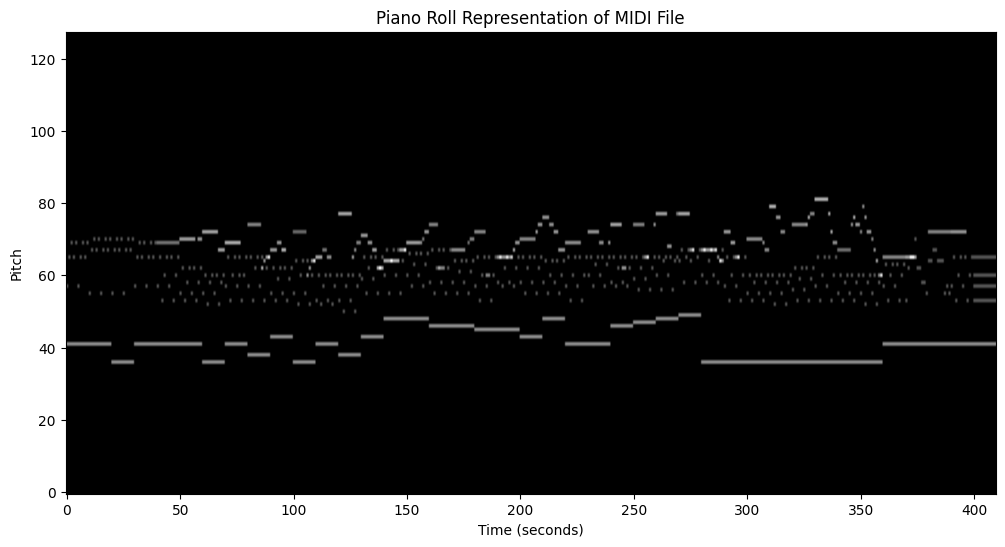

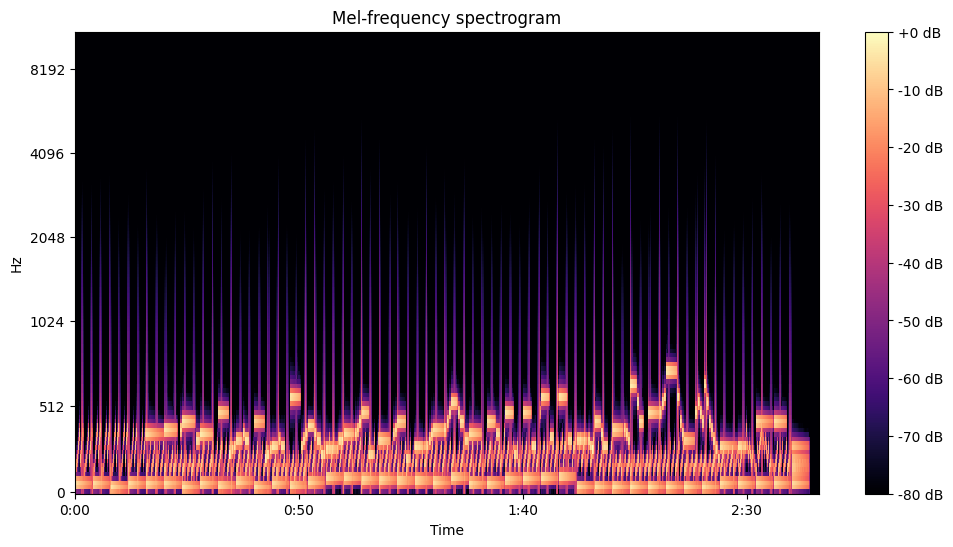

((128, 410), (128, 7150))

In [21]:
song = songs[0]
song.print_piano_roll()
song.create_spectrogram()
song.print_spectrogram()

song.piano_roll.shape, song.spectrogram.shape

Min length: 256
max_length: 4981
Number of songs: 1076


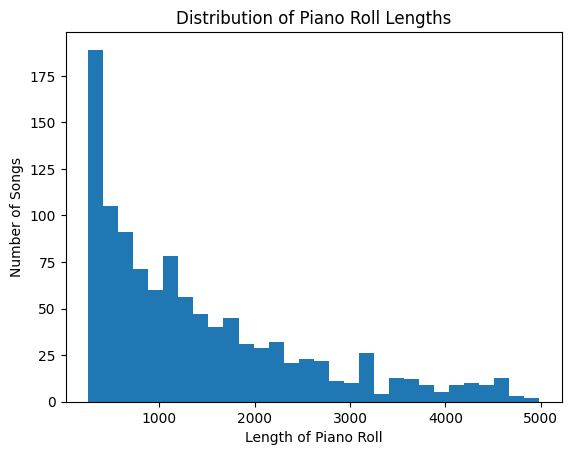

In [23]:
## find min and max length of piano roll
min_length = 999999
max_length = 0

for song in songs:
    if song.piano_roll.shape[1] < min_length:
        min_length = song.piano_roll.shape[1]
    if song.piano_roll.shape[1] > max_length:
        max_length = song.piano_roll.shape[1]

# remove songs that are more than 10000 timesteps
songs = [song for song in songs if song.piano_roll.shape[1] <= 5000]

# remove songs that are less than 1000 timesteps
songs = [song for song in songs if song.piano_roll.shape[1] >= 256]

print(f"Min length: {min_length}")
print(f"max_length: {max_length}")
print(f"Number of songs: {len(songs)}")

# plot distribution of lengths
lengths = [song.piano_roll.shape[1] for song in songs]
plt.hist(lengths, bins=30)
plt.xlabel('Length of Piano Roll')
plt.ylabel('Number of Songs')
plt.title('Distribution of Piano Roll Lengths')
plt.show()


In [24]:
# buckets for composer
buckets_songs = {}

# print number of songs per composer
for song in songs:
    if song.composer not in buckets_songs:
        buckets_songs[song.composer] = 0
    buckets_songs[song.composer] += 1

# print number of songs per composer
for composer, song_count in buckets_songs.items():
    print(f"Composer {composer} has {song_count} songs")

# create windows for each song
i = 0
for song in songs:
    i += 1
    song.create_windows() # THIS IS VERY SLOW - 26 minutes for last run on ~1070 songs
    song.create_spec_windows() 
    # progress
    print(f"{i} songs processed", end='\r')

buckets_windows = {}
# get windows for each composer
for song in songs:
    if song.composer not in buckets_windows:
        buckets_windows[song.composer] = 0
    buckets_windows[song.composer] += len(song.windows)

# print number of windows per composer
for composer, windows in buckets_windows.items():
    print(f"Composer {composer} has {windows} windows")

Composer Bach has 541 songs
Composer Beethoven has 175 songs
Composer Chopin has 122 songs
Composer Mozart has 238 songs
Composer Bach has 1985 windows
Composer Beethoven has 1331 windows
Composer Chopin has 487 windows
Composer Mozart has 1619 windows


In [ ]:
### I can't do this yet, I need some way of mapping the spectrograms to the right songs in the song object. They need to know which song they came from. Maybe song track file path in the song object?

def save_spectrograms(songs, base_path='spectrograms'):
    os.makedirs(base_path, exist_ok=True)
    i = 0
    for song in songs:
        spectrogram = song.spectrogram
        filename = f'spectrogram_{i}.png'
        filepath = os.path.join(base_path, filename)
        plt.imsave(filepath, spectrogram, cmap='viridis')
        songs = filepath  # Replace image data with filepath
        i += 1

# Assuming your spectrograms are in a list called 'spectrograms'
save_spectrograms(songs)

### Piano Rolls

In [25]:
# train test split

train_songs = {}
test_songs = {}

for song in songs:
    if song.composer_id not in test_songs:
        test_songs[song.composer_id] = []
    if len(test_songs[song.composer_id]) < 30:
        test_songs[song.composer_id].append(song)
    else:
        if song.composer_id not in train_songs:
            train_songs[song.composer_id] = []
        train_songs[song.composer_id].append(song)

train_songs = [song for composer_songs in train_songs.values() for song in composer_songs]
test_songs = [song for composer_songs in test_songs.values() for song in composer_songs]

# print number of training and testing songs for each composer
count_train = {}
count_test = {}

for song in train_songs:
    if song.composer_id not in count_train:
        count_train[song.composer_id] = 0
    count_train[song.composer_id] += 1

for song in test_songs:
    if song.composer_id not in count_test:
        count_test[song.composer_id] = 0
    count_test[song.composer_id] += 1

print(f"Training songs per composer{count_train}")
print(f"Testing songs per composer{count_test}")

# Create a dataset from the training songs
train_windows = []
train_labels = []

for song in train_songs:
    train_windows.extend(song.windows)
    train_labels.extend([song.composer_id] * len(song.windows))

train_windows = tf.stack(train_windows)
train_labels = tf.convert_to_tensor(train_labels)

print(f"Training windows shape: {train_windows.shape}")
print(f"Training labels shape: {train_labels.shape}")
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

test_windows = []
test_labels = []

for song in test_songs:
    test_windows.extend(song.windows)
    test_labels.extend([song.composer_id] * len(song.windows))

test_windows = tf.stack(test_windows)
test_labels = tf.convert_to_tensor(test_labels)

print(f"Testing windows shape: {test_windows.shape}")
print(f"Testing labels shape: {test_labels.shape}")
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

print(train_labels)

Training songs per composer{0: 511, 1: 145, 2: 92, 3: 208}
Testing songs per composer{0: 30, 1: 30, 2: 30, 3: 30}
Training windows shape: (4983, 128, 256)
Training labels shape: (4983,)
Distinct Training Samples {0: 1947, 1: 1183, 2: 391, 3: 1462}
Testing windows shape: (439, 128, 256)
Testing labels shape: (439,)
Distinct Training Samples {0: 38, 1: 148, 2: 96, 3: 157}
tf.Tensor([0 0 0 ... 3 3 3], shape=(4983,), dtype=int32)


In [26]:
# Convert train_windows and train_labels to numpy arrays
train_windows_np = train_windows.numpy()
train_labels_np = train_labels.numpy()

# SMOTE wants 2D input, need to flatten
n_samples, n_timesteps, n_features = train_windows_np.shape
train_windows_reshaped = train_windows_np.reshape((n_samples, -1))

smote = SMOTE(random_state=42)
train_windows_resampled, train_labels_resampled = smote.fit_resample(train_windows_reshaped, train_labels_np)

# Reshape the resampled windows back to 3D
train_windows_resampled = train_windows_resampled.reshape((-1, n_timesteps, n_features))

# Convert back to tensors
train_windows_balanced = tf.convert_to_tensor(train_windows_resampled)
train_labels_balanced = tf.convert_to_tensor(train_labels_resampled)

print(f"Balanced training windows shape: {train_windows_balanced.shape}")
print(f"Balanced training labels shape: {train_labels_balanced.shape}")
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print(f"Distinct Balanced Training Samples {dict(zip(unique, counts))}")

Balanced training windows shape: (7788, 128, 256)
Balanced training labels shape: (7788,)
Distinct Balanced Training Samples {0: 1947, 1: 1947, 2: 1947, 3: 1947}


In [27]:
# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# train the model
train_windows = tf.expand_dims(train_windows, axis=-1)
test_windows = tf.expand_dims(test_windows, axis=-1)

model.fit(train_windows, train_labels, epochs=3, batch_size=32, validation_data=(test_windows, test_labels))

Epoch 1/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 75s 473ms/step - accuracy: 0.5502 - loss: 22.0786 - val_accuracy: 0.5034 - val_loss: 1.1821
Epoch 2/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 476ms/step - accuracy: 0.7492 - loss: 0.6359 - val_accuracy: 0.4897 - val_loss: 1.7639
Epoch 3/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 472ms/step - accuracy: 0.8385 - loss: 0.4206 - val_accuracy: 0.5171 - val_loss: 2.0108


### Spectrograms

In [37]:
print(songs[0].spec_windows.shape)
print(songs[0].windows.shape)
print(songs[0].print_info())

# print the songs length using the midi file
print(songs[0].midi_data.get_end_time())

(27, 128, 256)
(1, 128, 256)
Composer: Bach
Composer ID: 0
Number of windows: 1
Window shape: (128, 256)
None
82.0


In [29]:
# Create a dataset from the training songs
train_windows = []
train_labels = []

for song in train_songs:
    train_windows.extend(song.spec_windows)
    train_labels.extend([song.composer_id] * len(song.spec_windows))

train_windows = tf.stack(train_windows)
train_labels = tf.convert_to_tensor(train_labels)

print(f"Training windows shape: {train_windows.shape}")
print(f"Training labels shape: {train_labels.shape}")
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

test_windows = []
test_labels = []

for song in test_songs:
    test_windows.extend(song.spec_windows)
    test_labels.extend([song.composer_id] * len(song.spec_windows))

test_windows = tf.stack(test_windows)
test_labels = tf.convert_to_tensor(test_labels)

print(f"Testing windows shape: {test_windows.shape}")
print(f"Testing labels shape: {test_labels.shape}")
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

print(train_labels)

Training windows shape: (93558, 128, 256)
Training labels shape: (93558,)
Distinct Training Samples {0: 37344, 1: 21611, 2: 7556, 3: 27047}
Testing windows shape: (8462, 128, 256)
Testing labels shape: (8462,)
Distinct Training Samples {0: 884, 1: 2771, 2: 1887, 3: 2920}
tf.Tensor([0 0 0 ... 3 3 3], shape=(93558,), dtype=int32)


In [31]:
# Convert train_windows and train_labels to numpy arrays
train_windows_np = train_windows.numpy()
train_labels_np = train_labels.numpy()

# SMOTE wants 2D input, need to flatten
n_samples, n_timesteps, n_features = train_windows_np.shape
train_windows_reshaped = train_windows_np.reshape((n_samples, -1))

smote = SMOTE(random_state=42)
train_windows_resampled, train_labels_resampled = smote.fit_resample(train_windows_reshaped, train_labels_np)

# Reshape the resampled windows back to 3D
train_windows_resampled = train_windows_resampled.reshape((-1, n_timesteps, n_features))

# Convert back to tensors
train_windows_balanced = tf.convert_to_tensor(train_windows_resampled)
train_labels_balanced = tf.convert_to_tensor(train_labels_resampled)

print(f"Balanced training windows shape: {train_windows_balanced.shape}")
print(f"Balanced training labels shape: {train_labels_balanced.shape}")
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print(f"Distinct Balanced Training Samples {dict(zip(unique, counts))}")

MemoryError: Unable to allocate 22.8 GiB for an array with shape (93558, 128, 256) and data type float64

In [ ]:
# create the model
spec_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

spec_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
train_windows = tf.expand_dims(train_windows, axis=-1)
test_windows = tf.expand_dims(test_windows, axis=-1)

spec_model.fit(train_windows, train_labels, epochs=3, batch_size=32, validation_data=(test_windows, test_labels))

### Eval

14/14 - 2s - 126ms/step - accuracy: 0.5034 - loss: 2.0156
Test accuracy: 0.5034168362617493
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step


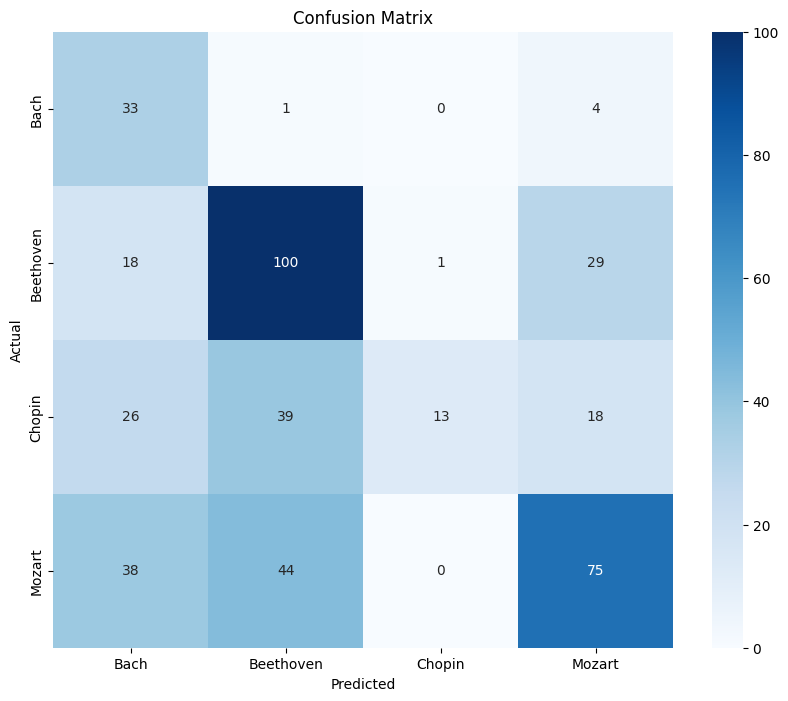

In [ ]:
# evaluate the model (on windows)
test_loss, test_acc = model.evaluate(test_windows, test_labels, verbose=2)
print('Test accuracy:', test_acc)

# confusion matrix (on windows)
predictions = model.predict(test_windows)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predictions, )
cm_df = pd.DataFrame(cm, index=num_composer_map.values(), columns=num_composer_map.values())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_song(model, song_windows):
    song_windows = tf.expand_dims(song_windows, axis=-1)
    window_predictions = model.predict(song_windows)
    summed_predictions = np.sum(window_predictions, axis=0)
    predicted_composer_id = np.argmax(summed_predictions)
    return predicted_composer_id

song_predictions = []
song_true_labels = []

for song in test_songs:
    predicted_composer_id = predict_song(model, song.windows)
    song_predictions.append(predicted_composer_id)
    song_true_labels.append(song.composer_id)

print(classification_report(song_true_labels, song_predictions, target_names=num_composer_map.values()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━